# Bitcoin Price Analysis Pipeline Orchestration

This notebook orchestrates the end-to-end pipeline for fetching Bitcoin price data, submitting an analysis job to Databricks, retrieving the results, and cleaning up resources, primarily using the Databricks CLI via Python wrappers from `databricks_cli_utils.py`.

**Workflow Overview:**
1. Create/Start a Databricks cluster using the CLI.
2. Fetch current Bitcoin price data from CoinGecko API locally.
3. Upload the fetched data to DBFS using the CLI.
4. Submit the analysis notebook (`<Your Analysis Notebook Path>.py`) to run as a one-time job on the created cluster using the CLI (`databricks runs submit`).
5. Monitor the job run until completion using the CLI.
6. Download the analysis results (forecast data) from DBFS using the CLI.
7. Terminate the Databricks cluster using the CLI.
8. Load and display the downloaded results locally.

**Prerequisites:**
* Databricks CLI installed and configured (via `databricks configure --token` or environment variables).
* A `config/cluster_config.json` file defining a valid cluster specification.
* Your analysis notebook (e.g., the one performing ARIMA) uploaded to your Databricks Workspace. You will need its workspace path.
* The analysis notebook must be written to read input from a specific DBFS path (e.g., `dbfs:/bitcoin/bitcoin_price.json`) and write its output (e.g., forecast CSV) to another specific DBFS path (e.g., `dbfs:/bitcoin/forecast_output.csv`).

In [1]:
# %load_ext autoreload
# %autoreload 2

import logging
import os
import json
import time
import pandas as pd
import matplotlib.pyplot as plt

# Import our utility functions
import databricks_cli_utils as dcu

# Configure logging
if not logging.getLogger().hasHandlers():
     logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
_LOG = logging.getLogger(__name__)
logging.getLogger('databricks_cli_utils').setLevel(logging.DEBUG)

# --- Configuration ---
CLUSTER_CONFIG_PATH = "config/cluster_config.json"
CLUSTER_ID_FILE = "config/cluster_id.txt"

# Local data paths
LOCAL_DATA_DIR = "data"
LOCAL_FETCHED_FILENAME = "bitcoin_price.json"
LOCAL_FETCHED_PATH = os.path.join(LOCAL_DATA_DIR, LOCAL_FETCHED_FILENAME)
LOCAL_RESULTS_FILENAME = "forecast_output_live.csv"
LOCAL_RESULTS_PATH = os.path.join(LOCAL_DATA_DIR, LOCAL_RESULTS_FILENAME)
LOCAL_PLOT_DIR = "output_plots"
LOCAL_FORECAST_PLOT_PATH = os.path.join(LOCAL_PLOT_DIR, "forecast_plot_live.png")

# DBFS paths
DBFS_BASE_DIR = "dbfs:/bitcoin" 
DBFS_UPLOAD_PATH = f"{DBFS_BASE_DIR}/{LOCAL_FETCHED_FILENAME}"
DBFS_RESULTS_PATH = f"{DBFS_BASE_DIR}/forecast_output.csv"

# !! IMPORTANT: Replace with the actual Workspace path to your analysis notebook !!
# Example: "/Users/your_email@domain.com/Bitcoin_Analysis_Notebook"
ANALYSIS_NOTEBOOK_PATH = "/Workspace/bitcoin_analysis"

# Ensure local directories exist
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
os.makedirs(LOCAL_PLOT_DIR, exist_ok=True)

# Variables for state tracking
cluster_id = None
run_id = None

print("Setup complete.")
print(f"Local data path: {LOCAL_FETCHED_PATH}")
print(f"DBFS upload path: {DBFS_UPLOAD_PATH}")
print(f"DBFS results path: {DBFS_RESULTS_PATH}")
print(f"Local results path: {LOCAL_RESULTS_PATH}")
print(f"Analysis notebook path: {ANALYSIS_NOTEBOOK_PATH}")



Setup complete.
Local data path: data\bitcoin_price.json
DBFS upload path: dbfs:/bitcoin/bitcoin_price.json
DBFS results path: dbfs:/bitcoin/forecast_output.csv
Local results path: data\forecast_output_live.csv
Analysis notebook path: /Workspace/bitcoin_analysis


## 1. Start Cluster

First, we ensure a cluster is running using the configuration specified in `config/cluster_config.json`. We use the CLI wrapper and wait until the cluster state is "RUNNING".

---
**Note:** This cell interacts live with Databricks and requires CLI configuration. Cluster creation takes several minutes.
---

In [2]:
_LOG.info("--- Step 1: Starting Cluster ---")
print("Step 1: Starting Cluster...")

# Check if cluster ID file exists from a previous run
if os.path.exists(CLUSTER_ID_FILE):
    try:
        with open(CLUSTER_ID_FILE, 'r') as f:
            cluster_id = f.read().strip()
        print(f"Found existing cluster ID: {cluster_id}. Checking status...")
        status = dcu.get_cluster_status_cli(cluster_id)
        if status not in ["TERMINATED", "ERROR", None]:
             print(f"Cluster {cluster_id} status is {status}.")
        else:
             print(f"Cluster {cluster_id} is {status}. Will create a new one.")
             cluster_id = None
             os.remove(CLUSTER_ID_FILE)
    except Exception as e:
         print(f"Error reading cluster ID file: {e}. Will create a new cluster.")
         cluster_id = None

if not cluster_id:
    if not os.path.exists(CLUSTER_CONFIG_PATH):
        print(f"ERROR: Cluster config file not found at {CLUSTER_CONFIG_PATH}. Cannot proceed.")
        raise FileNotFoundError(f"Missing required file: {CLUSTER_CONFIG_PATH}")
    else:
        print(f"Creating new cluster from {CLUSTER_CONFIG_PATH}...")
        cluster_id = dcu.create_cluster_cli(CLUSTER_CONFIG_PATH, CLUSTER_ID_FILE)

if not cluster_id:
    print("ERROR: Failed to get a valid cluster ID. Stopping execution.")
    raise RuntimeError("Failed to create or identify a cluster.")
else:
    print(f"Waiting for cluster {cluster_id} to be RUNNING...")
    max_wait_seconds = 6000
    start_time = time.time()
    while time.time() - start_time < max_wait_seconds:
        status = dcu.get_cluster_status_cli(cluster_id)
        print(f"Current status: {status} (Elapsed: {int(time.time() - start_time)}s)")
        if status == "RUNNING":
            print(f"Cluster {cluster_id} is RUNNING.")
            break
        elif status in ["TERMINATED", "ERROR", "UNKNOWN", None]:
            print(f"ERROR: Cluster entered unexpected state {status}. Stopping.")
            cluster_id = None
            raise RuntimeError(f"Cluster failed to start (state: {status}).")
            break
        time.sleep(30)
    else:
        print(f"ERROR: Cluster did not become RUNNING within {max_wait_seconds} seconds. Stopping.")
        dcu.delete_cluster_cli(cluster_id)
        cluster_id = None
        raise TimeoutError("Cluster start timed out.")

if cluster_id:
     print("--- Step 1 Complete: Cluster Ready ---")
else:
     print("--- Step 1 Failed ---")

2025-05-01 22:32:46,529 - __main__ - INFO - --- Step 1: Starting Cluster ---
2025-05-01 22:32:46,540 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-021009-s5wlolgf


Step 1: Starting Cluster...
Found existing cluster ID: 0502-021009-s5wlolgf. Checking status...


2025-05-01 22:32:48,753 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:32:48,754 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:32:48,754 - databricks_cli_utils - INFO - Cluster '0502-021009-s5wlolgf' status: TERMINATED
2025-05-01 22:32:48,757 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters create --json-file config/cluster_config.json


Cluster 0502-021009-s5wlolgf is TERMINATED. Will create a new one.
Creating new cluster from config/cluster_config.json...


2025-05-01 22:32:51,249 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:32:51,250 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:32:51,252 - databricks_cli_utils - INFO - Submitted cluster creation. ID: 0502-023251-qbwdbil0
2025-05-01 22:32:51,253 - databricks_cli_utils - INFO - Saved cluster ID to config/cluster_id.txt
2025-05-01 22:32:51,254 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0


Waiting for cluster 0502-023251-qbwdbil0 to be RUNNING...


2025-05-01 22:32:53,260 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:32:53,260 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:32:53,261 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 2s)


2025-05-01 22:33:23,262 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:33:25,475 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:33:25,476 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:33:25,476 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 34s)


2025-05-01 22:33:55,479 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:33:57,824 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:33:57,825 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:33:57,826 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 66s)


2025-05-01 22:34:27,827 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:34:29,956 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:34:29,957 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:34:29,958 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 98s)


2025-05-01 22:34:59,959 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:35:02,263 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:35:02,264 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:35:02,265 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 131s)


2025-05-01 22:35:32,267 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:35:34,542 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:35:34,543 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:35:34,543 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 163s)


2025-05-01 22:36:04,546 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:36:06,727 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:36:06,728 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:36:06,729 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 195s)


2025-05-01 22:36:36,730 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:36:39,235 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:36:39,236 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:36:39,237 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 227s)


2025-05-01 22:37:09,239 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:37:11,440 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:37:11,440 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:37:11,441 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 260s)


2025-05-01 22:37:41,442 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:37:43,714 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:37:43,715 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:37:43,715 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 292s)


2025-05-01 22:38:13,717 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:38:15,946 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:38:15,947 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:38:15,948 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 324s)


2025-05-01 22:38:45,950 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:38:48,271 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:38:48,271 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:38:48,272 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: PENDING


Current status: PENDING (Elapsed: 357s)


2025-05-01 22:39:18,274 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters get --cluster-id 0502-023251-qbwdbil0
2025-05-01 22:39:20,385 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:39:20,385 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:39:20,386 - databricks_cli_utils - INFO - Cluster '0502-023251-qbwdbil0' status: RUNNING


Current status: RUNNING (Elapsed: 389s)
Cluster 0502-023251-qbwdbil0 is RUNNING.
--- Step 1 Complete: Cluster Ready ---


## 2. Fetch Bitcoin Data

Next, we fetch the latest Bitcoin price from the CoinGecko API and save it to a local JSON file.

In [3]:
if cluster_id:
    _LOG.info("--- Step 2: Fetching Bitcoin Data ---")
    print("\nStep 2: Fetching Bitcoin Data...")
    local_data_path = dcu.fetch_bitcoin_data(
        output_dir=LOCAL_DATA_DIR,
        output_filename=LOCAL_FETCHED_FILENAME
    )
    if local_data_path:
        print(f"Data saved locally to: {local_data_path}")
        print("--- Step 2 Complete ---")
    else:
        print("ERROR: Failed to fetch Bitcoin data. Stopping execution.")
else:
    print("Skipping Step 2 due to cluster failure.")

2025-05-01 22:39:20,397 - __main__ - INFO - --- Step 2: Fetching Bitcoin Data ---
2025-05-01 22:39:20,557 - databricks_cli_utils - INFO - Fetched/saved Bitcoin price: $96991 to data\bitcoin_price.json



Step 2: Fetching Bitcoin Data...
Data saved locally to: data\bitcoin_price.json
--- Step 2 Complete ---


## 3. Upload Data to DBFS

We upload the locally fetched data file to DBFS so the analysis job running on the cluster can access it.

---
**Note:** This cell interacts live with Databricks and requires CLI configuration.
---

In [4]:
if cluster_id and local_data_path:
    _LOG.info("--- Step 3: Uploading Data to DBFS ---")
    print("\nStep 3: Uploading Data to DBFS...")
    print(f"Uploading {local_data_path} to {DBFS_UPLOAD_PATH}")
    success = dcu.upload_to_dbfs_cli(
        local_path=local_data_path,
        dbfs_path=DBFS_UPLOAD_PATH,
        overwrite=True
    )
    if success:
        print("Upload successful.")
        print("--- Step 3 Complete ---")
    else:
        print("ERROR: Failed to upload data to DBFS. Stopping execution.")
else:
    print("Skipping Step 3 due to previous failure.")

2025-05-01 22:39:20,571 - __main__ - INFO - --- Step 3: Uploading Data to DBFS ---
2025-05-01 22:39:20,573 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks fs cp 'data\bitcoin_price.json' dbfs:/bitcoin/bitcoin_price.json --overwrite



Step 3: Uploading Data to DBFS...
Uploading data\bitcoin_price.json to dbfs:/bitcoin/bitcoin_price.json


2025-05-01 22:39:23,013 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:39:23,014 - databricks_cli_utils - DEBUG - Command successful, output is not JSON.
2025-05-01 22:39:23,014 - databricks_cli_utils - INFO - Uploaded 'data\bitcoin_price.json' to 'dbfs:/bitcoin/bitcoin_price.json'


Upload successful.
--- Step 3 Complete ---


## 4. Submit Analysis Run

Now we submit the analysis notebook to run as a one-time job on the cluster we created. We use the `databricks runs submit` command (via a wrapper) for this.

---
**Note:** This cell interacts live with Databricks and requires CLI configuration. Ensure the `ANALYSIS_NOTEBOOK_PATH` variable is set correctly to the path of your analysis notebook in the Databricks workspace.
---

In [5]:
if cluster_id and local_data_path and success:
    _LOG.info("--- Step 4: Submitting Analysis Run ---")
    print("\nStep 4: Submitting Analysis Run...")
    print(f"Submitting notebook {ANALYSIS_NOTEBOOK_PATH} to run on cluster {cluster_id}")

    run_id = dcu.submit_notebook_run_cli(
        notebook_path=ANALYSIS_NOTEBOOK_PATH,
        cluster_id=cluster_id
    )

    if run_id:
        print(f"Run submitted successfully. Run ID: {run_id}")
        print("--- Step 4 Complete ---")
    else:
        print("ERROR: Failed to submit run. Stopping execution.")
else:
    print("Skipping Step 4 due to previous failure.")

2025-05-01 22:39:23,023 - __main__ - INFO - --- Step 4: Submitting Analysis Run ---
2025-05-01 22:39:23,024 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks runs submit --json '{"existing_cluster_id": "0502-023251-qbwdbil0", "notebook_task": {"notebook_path": "/Workspace/bitcoin_analysis"}, "run_name": "NotebookRun_bitcoin_analysis_1746153563"}'



Step 4: Submitting Analysis Run...
Submitting notebook /Workspace/bitcoin_analysis to run on cluster 0502-023251-qbwdbil0


2025-05-01 22:39:25,565 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:39:25,565 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:39:25,565 - databricks_cli_utils - INFO - Successfully submitted run for notebook '/Workspace/bitcoin_analysis' on cluster '0502-023251-qbwdbil0'. Run ID: 934060604303925


Run submitted successfully. Run ID: 934060604303925
--- Step 4 Complete ---


## 5. Monitor Job Run Completion

The analysis job runs asynchronously on Databricks. We need to poll its status using the `run_id` until it completes.

---
**Note:** This cell interacts live with Databricks and requires CLI configuration. It will wait for the job to finish.
---

In [6]:
job_success = False
if cluster_id and run_id:
    _LOG.info("--- Step 5: Monitoring Run Completion ---")
    print(f"\nStep 5: Monitoring Run {run_id}...")
    max_wait_job_seconds = 18000
    start_time_job = time.time()
    final_state = None
    while time.time() - start_time_job < max_wait_job_seconds:
        run_state = dcu.get_job_run_status_cli(run_id)
        if run_state:
            life_cycle_state = run_state.get('life_cycle_state', 'UNKNOWN')
            result_state = run_state.get('result_state', None)
            print(f"Current run status: {life_cycle_state} (Result: {result_state}, Elapsed: {int(time.time() - start_time_job)}s)")

            if life_cycle_state in ["TERMINATED", "SKIPPED", "INTERNAL_ERROR"]:
                final_state = run_state
                if result_state == "SUCCESS":
                    print(f"Run {run_id} completed successfully.")
                    job_success = True
                else:
                    print(f"ERROR: Run {run_id} finished with state {life_cycle_state} / {result_state}. Message: {run_state.get('state_message', 'N/A')}")
                break 
        else:
            print("Warning: Could not retrieve run status. Retrying...")
            

        time.sleep(60) 
    else: 
        print(f"ERROR: Run {run_id} did not complete within {max_wait_job_seconds} seconds. Stopping.")
        
        job_success = False

    if job_success:
        print("--- Step 5 Complete: Run Succeeded ---")
    else:
        print("--- Step 5 Failed ---")

else:
    print("Skipping Step 5 due to previous failure.")

2025-05-01 22:39:25,579 - __main__ - INFO - --- Step 5: Monitoring Run Completion ---
2025-05-01 22:39:25,580 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks runs get --run-id 934060604303925



Step 5: Monitoring Run 934060604303925...


2025-05-01 22:39:27,560 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:39:27,561 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:39:27,562 - databricks_cli_utils - INFO - Job run '934060604303925' status: RUNNING


Current run status: RUNNING (Result: None, Elapsed: 1s)


2025-05-01 22:40:27,562 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks runs get --run-id 934060604303925
2025-05-01 22:40:29,601 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:40:29,602 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:40:29,602 - databricks_cli_utils - INFO - Job run '934060604303925' status: RUNNING


Current run status: RUNNING (Result: None, Elapsed: 64s)


2025-05-01 22:41:29,604 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks runs get --run-id 934060604303925
2025-05-01 22:41:31,632 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:41:31,633 - databricks_cli_utils - DEBUG - Parsed JSON output.
2025-05-01 22:41:31,634 - databricks_cli_utils - INFO - Job run '934060604303925' status: TERMINATED


Current run status: TERMINATED (Result: SUCCESS, Elapsed: 126s)
Run 934060604303925 completed successfully.
--- Step 5 Complete: Run Succeeded ---


## 6. Download Results from DBFS

If the job run was successful, the analysis notebook should have saved the forecast results to DBFS. We now download that file locally.

---
**Note:** This cell interacts live with Databricks and requires CLI configuration. It assumes the analysis notebook saved results to `DBFS_RESULTS_PATH`.
---

In [7]:
results_downloaded = False
if cluster_id and job_success:
    _LOG.info("--- Step 6: Downloading Results ---")
    print("\nStep 6: Downloading Results...")
    print(f"Downloading {DBFS_RESULTS_PATH} to {LOCAL_RESULTS_PATH}")
    success = dcu.download_from_dbfs_cli(
        dbfs_path=DBFS_RESULTS_PATH,
        local_path=LOCAL_RESULTS_PATH,
        overwrite=True
    )
    if success:
        print(f"Results downloaded successfully to {LOCAL_RESULTS_PATH}")
        results_downloaded = True
        print("--- Step 6 Complete ---")
    else:
        print(f"ERROR: Failed to download results from {DBFS_RESULTS_PATH}. Check if the analysis job saved the output correctly.")
else:
     print("Skipping Step 6 due to previous failure or job failure.")

2025-05-01 22:41:31,645 - __main__ - INFO - --- Step 6: Downloading Results ---
2025-05-01 22:41:31,647 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks fs cp dbfs:/bitcoin/forecast_output.csv 'data\forecast_output_live.csv' --overwrite



Step 6: Downloading Results...


2025-05-01 22:41:34,227 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:41:34,228 - databricks_cli_utils - DEBUG - Command successful, output is not JSON.
2025-05-01 22:41:34,228 - databricks_cli_utils - INFO - Downloaded 'dbfs:/bitcoin/forecast_output.csv' to 'data\forecast_output_live.csv'


Results downloaded successfully to data\forecast_output_live.csv
--- Step 6 Complete ---


## 7. Terminate Cluster

Now that we have the results (or the job failed), we terminate the cluster to stop incurring costs.

---
**Note:** This cell interacts live with Databricks and requires CLI configuration.
---

In [8]:
if cluster_id:
    _LOG.info("--- Step 7: Terminating Cluster ---")
    print(f"\nStep 7: Terminating Cluster {cluster_id}...")
    deleted = dcu.delete_cluster_cli(cluster_id)
    if deleted:
        print(f"Cluster {cluster_id} deletion request submitted.")
        if os.path.exists(CLUSTER_ID_FILE):
             try:
                 os.remove(CLUSTER_ID_FILE)
                 print(f"Removed cluster ID file: {CLUSTER_ID_FILE}")
             except OSError as e:
                 print(f"Warning: Could not remove cluster ID file {CLUSTER_ID_FILE}: {e}")
        cluster_id = None
        print("--- Step 7 Complete ---")
    else:
        print(f"ERROR: Failed to submit deletion request for cluster {cluster_id}. Manual cleanup may be required.")
else:
    print("Skipping Step 7 - no active cluster ID.")

2025-05-01 22:41:34,239 - __main__ - INFO - --- Step 7: Terminating Cluster ---
2025-05-01 22:41:34,240 - databricks_cli_utils - DEBUG - Running Databricks CLI command: databricks clusters delete --cluster-id 0502-023251-qbwdbil0



Step 7: Terminating Cluster 0502-023251-qbwdbil0...


2025-05-01 22:41:36,545 - databricks_cli_utils - DEBUG - CLI command successful.
2025-05-01 22:41:36,546 - databricks_cli_utils - DEBUG - Command successful, output is not JSON.
2025-05-01 22:41:36,547 - databricks_cli_utils - INFO - Submitted deletion request for cluster '0502-023251-qbwdbil0'


Cluster 0502-023251-qbwdbil0 deletion request submitted.
Removed cluster ID file: config/cluster_id.txt
--- Step 7 Complete ---


## 8. Load and Display Results

If the results were downloaded successfully, we load the CSV file and display the forecast data.

In [9]:
forecast_df = None
if results_downloaded:
    _LOG.info("--- Step 8: Loading Downloaded Results ---")
    print("\nStep 8: Loading Downloaded Results...")
    try:
        forecast_df = pd.read_csv(LOCAL_RESULTS_PATH, parse_dates=['timestamp'], index_col='timestamp')
        print(f"Successfully loaded forecast data from {LOCAL_RESULTS_PATH}")
        print("Forecast Head:")
        print(forecast_df.head())
        print("\nForecast Tail:")
        print(forecast_df.tail())
        print("--- Step 8 Complete ---")
    except Exception as e:
        print(f"ERROR: Failed to load or display results CSV from {LOCAL_RESULTS_PATH}: {e}")
        forecast_df = None
else:
    print("Skipping Step 8 - results not downloaded.")

2025-05-01 22:41:36,560 - __main__ - INFO - --- Step 8: Loading Downloaded Results ---



Step 8: Loading Downloaded Results...
Successfully loaded forecast data from data\forecast_output_live.csv
Forecast Head:
                            forecast_price      model  \
timestamp                                               
2025-05-02 02:54:20.555639    96940.169045  (0, 1, 1)   
2025-05-02 03:09:20.555639    96940.169045  (0, 1, 1)   
2025-05-02 03:24:20.555639    96940.169045  (0, 1, 1)   
2025-05-02 03:39:20.555639    96940.169045  (0, 1, 1)   
2025-05-02 03:54:20.555639    96940.169045  (0, 1, 1)   

                                          last_trained  
timestamp                                               
2025-05-02 02:54:20.555639  2025-05-02T02:40:43.624382  
2025-05-02 03:09:20.555639  2025-05-02T02:40:43.624382  
2025-05-02 03:24:20.555639  2025-05-02T02:40:43.624382  
2025-05-02 03:39:20.555639  2025-05-02T02:40:43.624382  
2025-05-02 03:54:20.555639  2025-05-02T02:40:43.624382  

Forecast Tail:
                            forecast_price      model  \
times

## 9. Visualize Results

Finally, we can visualize the forecast alongside the historical data (which we still have locally or can re-parse). We regenerate the plot locally using the downloaded forecast.

2025-05-01 22:41:36,964 - __main__ - INFO - --- Step 9: Visualizing Results ---
2025-05-01 22:41:37,045 - databricks_cli_utils - INFO - Parsed/cleaned data from data\bitcoin_price.json. Shape: (1185, 3)



Step 9: Visualizing Results...
Parsing historical data from data\bitcoin_price.json for plotting...
Generating forecast plot...


2025-05-01 22:41:37,167 - databricks_cli_utils - WARNING - Confidence interval columns ('lower_ci', 'upper_ci') not found, plotting forecast only.
2025-05-01 22:41:37,517 - databricks_cli_utils - INFO - Saved forecast plot to output_plots\forecast_plot_live.png


Forecast plot saved to output_plots\forecast_plot_live.png


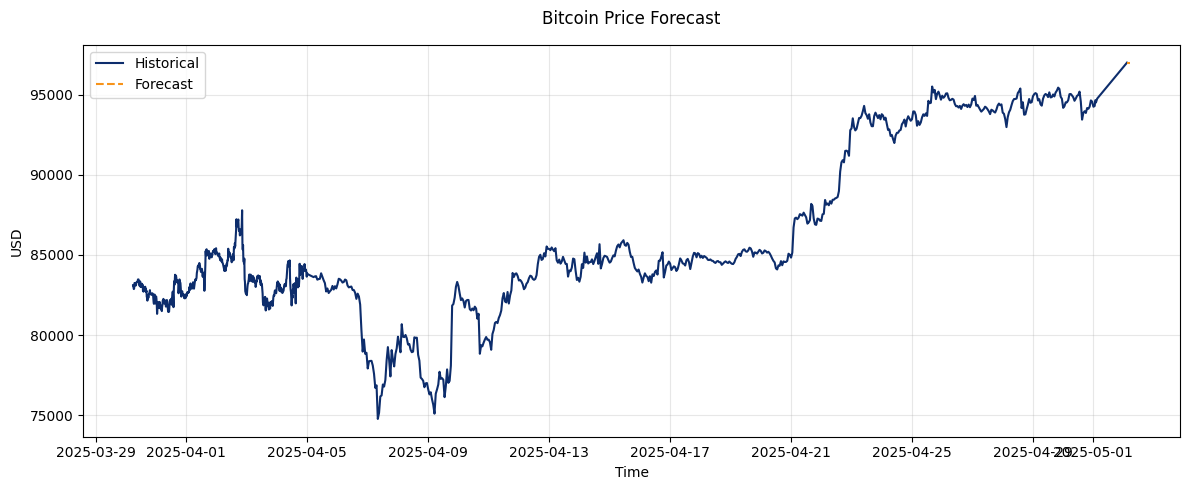

--- Step 9 Complete ---


In [10]:
if forecast_df is not None:
    _LOG.info("--- Step 9: Visualizing Results ---")
    print("\nStep 9: Visualizing Results...")
    print(f"Parsing historical data from {LOCAL_FETCHED_PATH} for plotting...")
    history_df = dcu.parse_local_json_data(LOCAL_FETCHED_PATH)

    if history_df is not None:
        print("Generating forecast plot...")
        dcu.plot_forecast_data(
            history=history_df,
            forecast_df=forecast_df,
            filename=LOCAL_FORECAST_PLOT_PATH
        )
        print(f"Forecast plot saved to {LOCAL_FORECAST_PLOT_PATH}")
        try:
            from IPython.display import Image
            display(Image(filename=LOCAL_FORECAST_PLOT_PATH))
            print("--- Step 9 Complete ---")
        except ImportError:
             print("Cannot display image inline (IPython not available or not running in notebook context).")
             print("--- Step 9 Complete (Plot Saved) ---")
        except Exception as e:
             print(f"Error displaying plot image: {e}")
             print("--- Step 9 Complete (Plot Saved) ---")

    else:
        print("ERROR: Could not parse historical data for plotting.")
else:
    print("Skipping Step 9 - forecast data not loaded.")

# if os.path.exists(LOCAL_FETCHED_PATH): os.remove(LOCAL_FETCHED_PATH)
# if os.path.exists(LOCAL_RESULTS_PATH): os.remove(LOCAL_RESULTS_PATH)
# print("\nLocal data/results files cleaned up.")

## End of Example Pipeline Orchestration